# Dual-Component Working Memory (DCWM)
## First-Order Memory binding task
## FF controller: input+interface/512/1024/512/output+interface
## Random Network forget_rate=1/3, net_size=1000, degree=20, interface_dim=350

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model import DCWM
from trainer import trainer

import pickle
import dill

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Generate or Loading training data

In [2]:
cols = 6
remembered = 2 # doesnt work with other number must change y by yourself
n=1000 # all posible sequences is (2^6)^2=4096

### X

In [3]:
x=np.random.randint(0,2,(1,1,cols))
for i in range(n):
    temp=np.random.randint(0,2,(1,1,cols))
    x=np.append(x,temp,axis=0)

In [4]:
#x

## Y

In [5]:
#for first
temp=np.zeros((1,1,remembered*cols))
temp[0,0,:cols]=x[0,0,:]
temp[0,0,cols:]=x[-1:,0,:]
y=temp

#for others
i=1
while i<=n:
    temp=np.zeros((1,1,remembered*cols))
    temp[0,0,:cols]=x[i,0,:]
    temp[0,0,cols:]=x[i-1,0,:]
    y=np.append(y,temp,axis=0)
    i=i+1


In [6]:
#y

In [7]:
#saving train set for first run
#This section must deactivate when you want loading
#dill.dump(x, file = open("x.pickle", "wb"))
#dill.dump(y, file = open("y.pickle", "wb"))

In [8]:
#loading train set for next runs
#This section must deactivate when you want new train
x=dill.load(open("x.pickle", "rb"))
y=dill.load(open("y.pickle", "rb"))

### see data format

In [9]:
np.shape(x)

(1001, 1, 6)

In [10]:
np.shape(y)

(1001, 1, 12)

## Initialize and train model

Initialize or loading:

In [11]:
interface_vactor_dim=350 #defult

In [12]:
dcwm = DCWM(input_dim=cols,controller_dime=512,interface_dim=interface_vactor_dim,netsize=1000)
history=[]

In [13]:
#Loading model and history
#This section must deactivate when you want new train
dcwm= dill.load(open("trained_dcwm.pickle", "rb"))
history= dill.load(open("history.pickle", "rb"))

Train:

In [14]:
#n*epochs=all_number_of_epochs_with_this_training_rate
n=0 #set 0 in loading the model, set 10 in trainig the model
lastnum=0 #last number of last run_shows in previous step and saved
epochsnum=10

In [15]:
#I use loop because I dont have powerfull device to run whole epochs at ones and I need save and check point in each round
for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)

    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))


In [16]:
#n*epochs=all_number_of_epochs_with_this_training_rate
n=0 #set 0 in loading the model, set 10 in trainig the model
lastnum=10 #last number of last run_shows in previous step and saved 
epochsnum=10

In [17]:
#I use loop because I dont have powerfull device to run whole epochs at ones and I need save and check point in each round
for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)

    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))


## History and Convergence

In [18]:
#history

In [19]:
np.size(history)
xyz=np.zeros(np.size(history))
for i in range(np.size(history)):
    xyz[i]=i

<IPython.core.display.Javascript object>


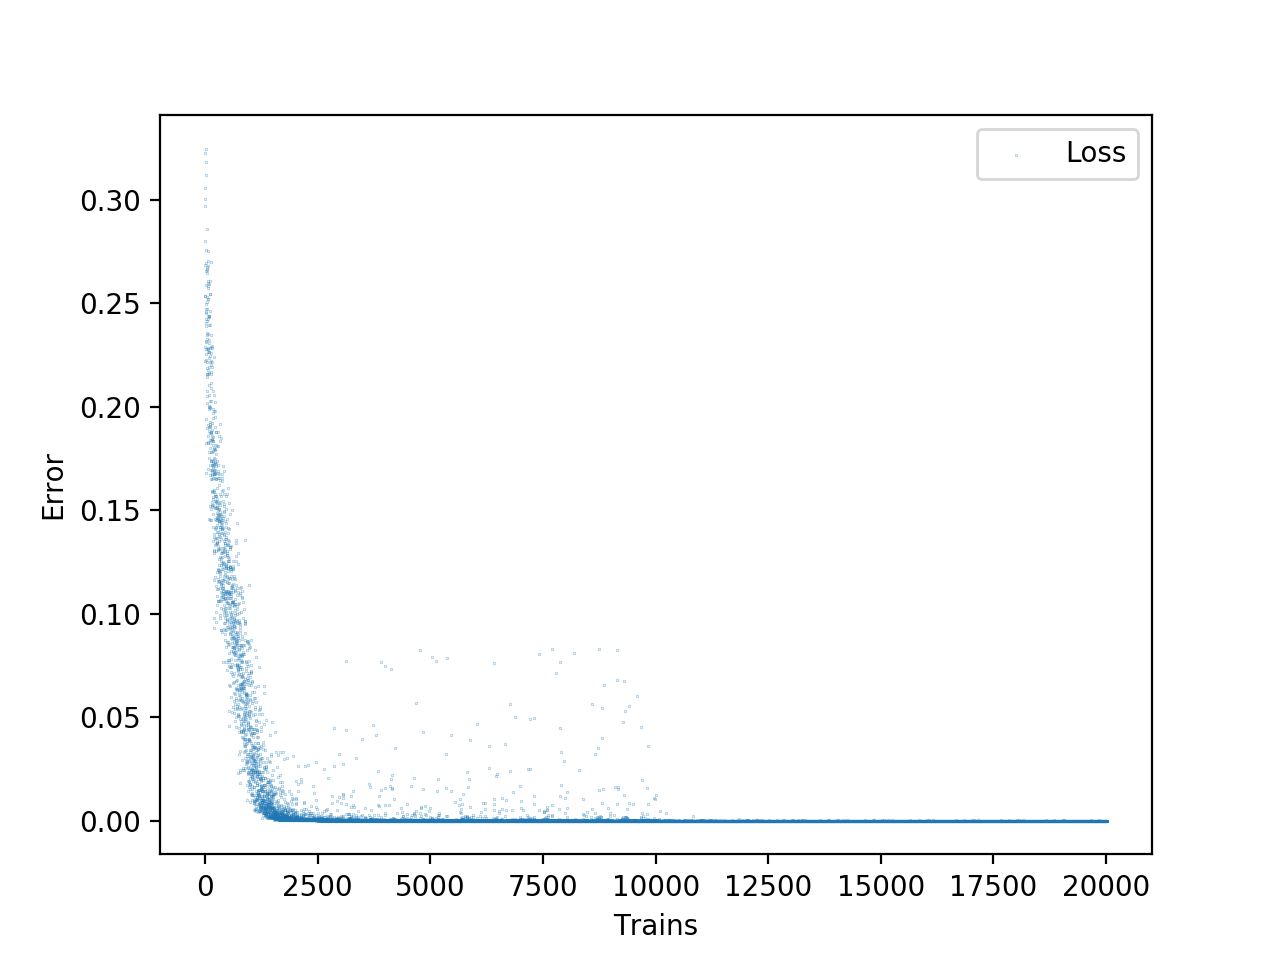

In [20]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #for HQ Fig
plt.scatter(xyz, history,0.01 ,label='Loss')
plt.xlabel('Trains')
plt.ylabel('Error')
plt.legend()
plt.show()
#fig.savefig('FirstOrderBindingTaskConvergencetrains.png')

<IPython.core.display.Javascript object>


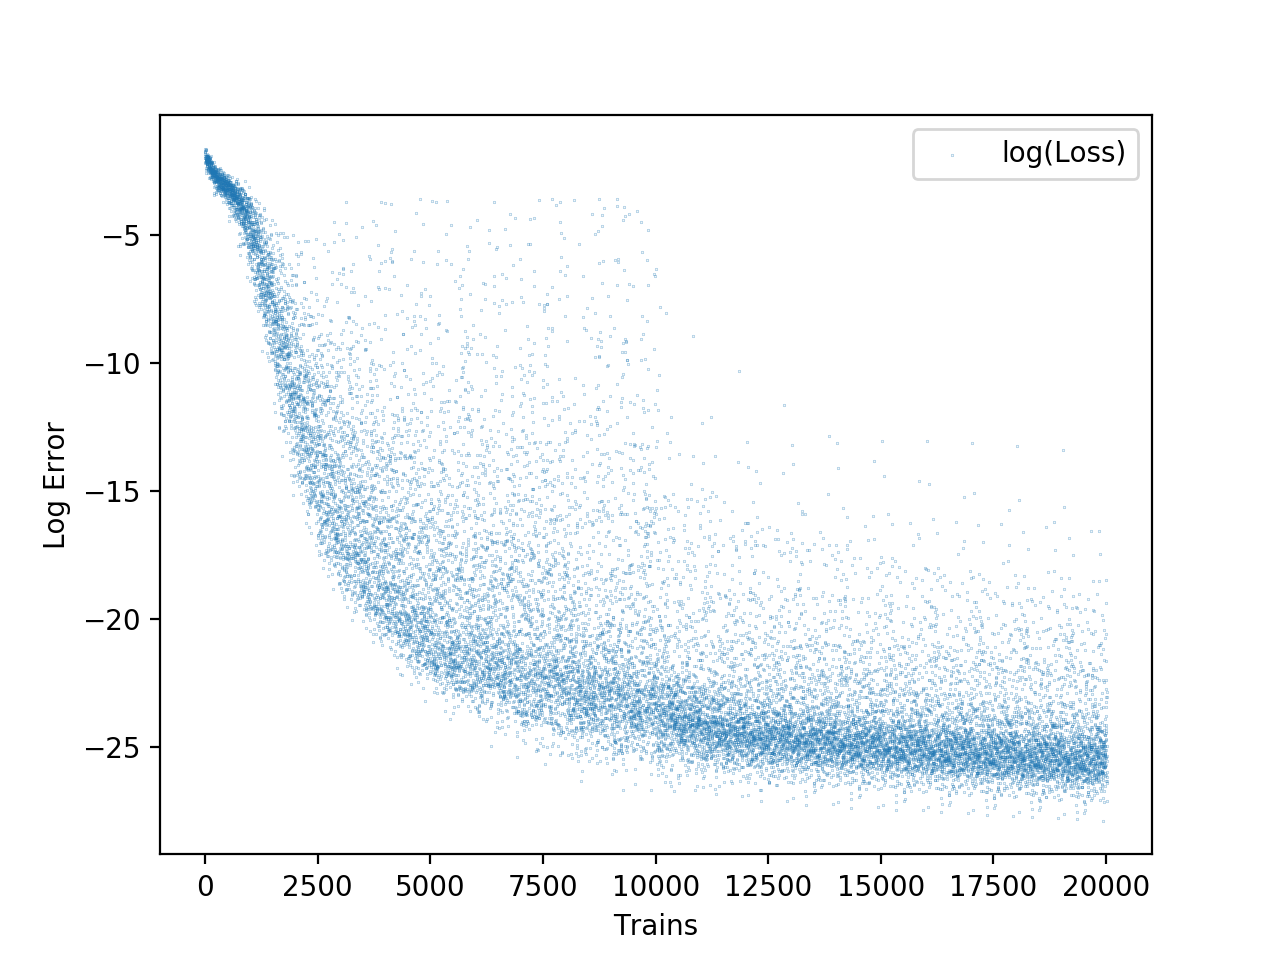

In [21]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600)
plt.scatter(xyz, np.log2(history),0.01 ,label='log(Loss)')
plt.xlabel('Trains')
plt.ylabel('Log Error')
plt.legend()
plt.show()
#fig.savefig('FirstOrderBindingTaskLOGConvergencetrains.png')

## Pridiction

Predict on `new X_test`:

In [22]:
test_num=19 #number of test set minus one
x_test=np.random.randint(0,2,(1,1,cols))
for i in range(test_num):
    temp=np.random.randint(0,2,(1,1,cols))
    x_test=np.append(x_test,temp,axis=0)

In [23]:
#x_test

In [24]:
y_test=np.concatenate((x_test[0],x[-1]),axis=1)
y_test=y_test.reshape(1,1,cols*2)
for i in range(test_num):
    temp=np.reshape(np.concatenate((x_test[i+1],x_test[i]),axis=1),(1,1,2*cols))
    y_test=np.append(y_test,temp,axis=0)

In [25]:
#y_test

In [26]:
y_test_show=np.zeros((cols*2,test_num+1))
test_num=test_num+1
for i in range(cols*2):
    for j in range(test_num):
        y_test_show[i,j]=y_test[j,0,i]

In [27]:
y_temp , v = dcwm(x_test[0]) 
y_pred=y_temp.numpy().reshape(1,2*cols)
i=1
while i < test_num:
    y_pred_temp , v = dcwm(x_test[i]) 
    y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,2*cols),0)
    i=i+1
    
y_pred=y_pred.T

In [28]:
np.shape(y_pred)

(12, 20)

In [29]:
np.shape(v)

(40, 1, 350)

## Plot Data Remembering

<IPython.core.display.Javascript object>


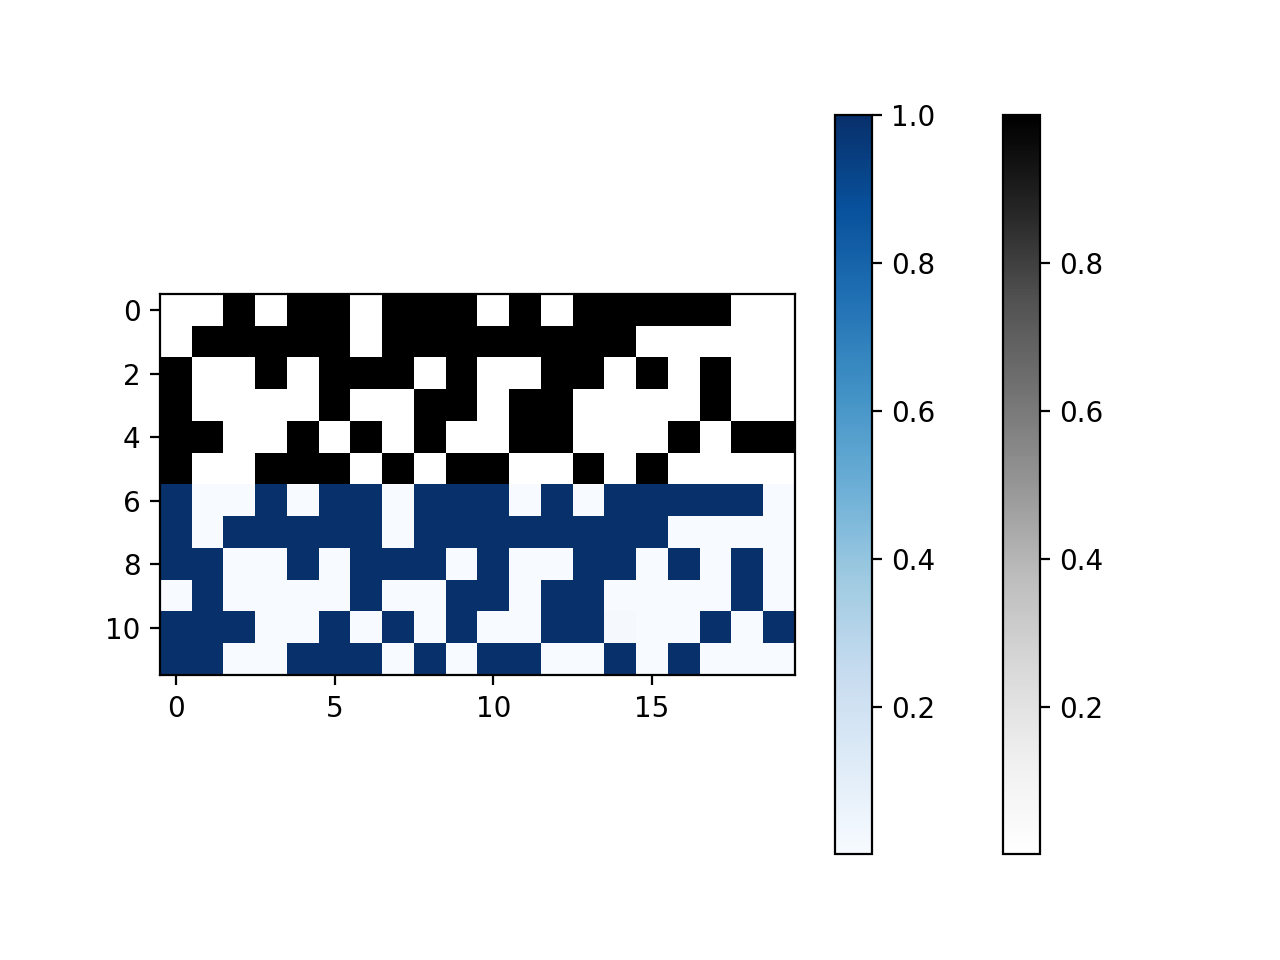

In [30]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600)
copy = np.full(y_pred.shape, np.nan)
rem = np.full(y_pred.shape, np.nan)
copy[:cols,:] = y_pred[:cols,:]
rem[cols:,:] = y_pred[cols:,:]
plt.imshow(copy,cmap='Greys')
plt.colorbar()
plt.imshow(rem,cmap='Blues')
plt.colorbar()
#fig.savefig('REMfirstorder.png')

<IPython.core.display.Javascript object>


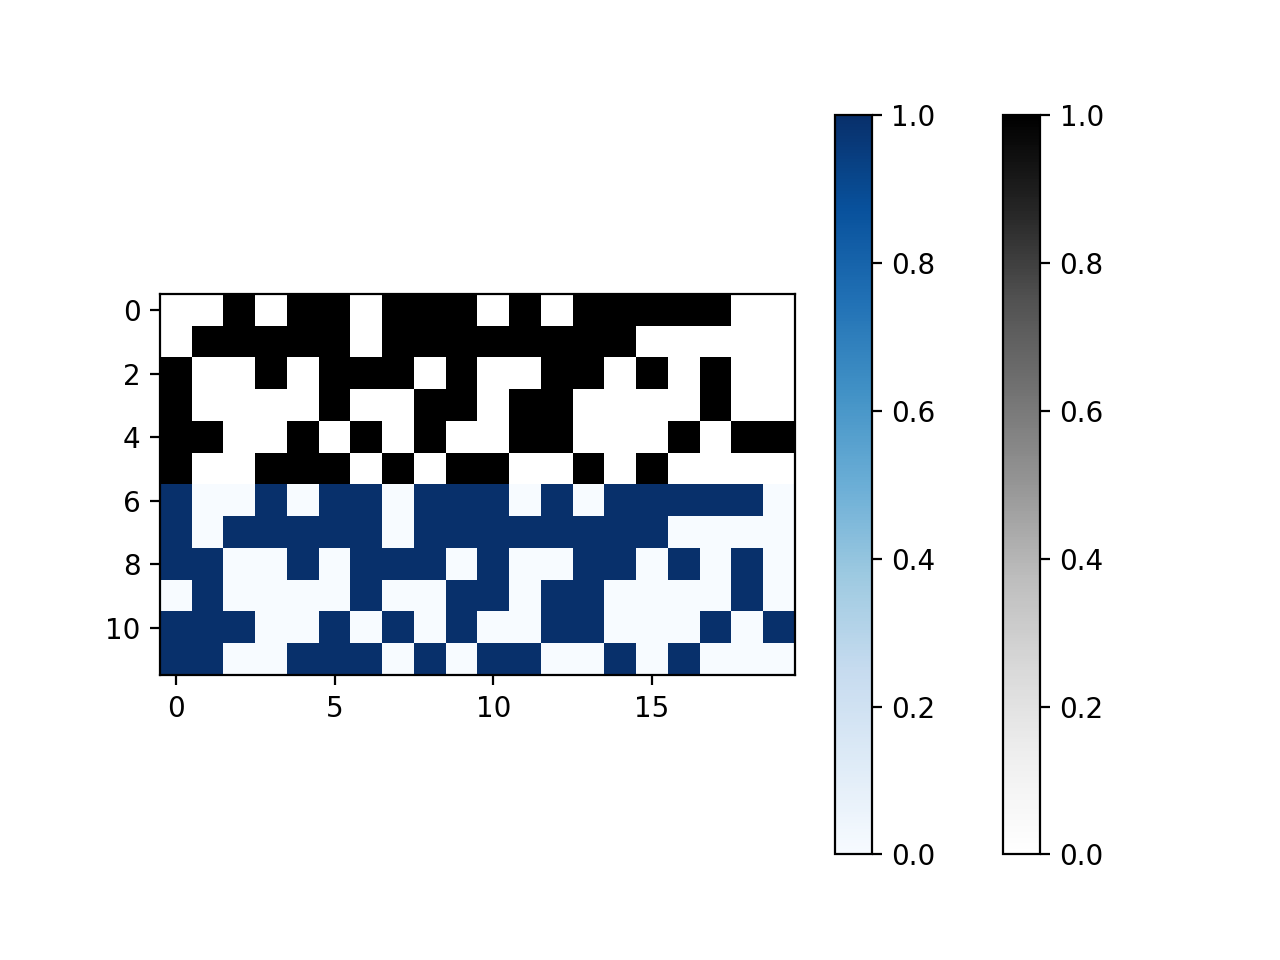

In [31]:
#showing Real y_test
%matplotlib notebook 
copy = np.full(y_test_show.shape, np.nan)
rem = np.full(y_test_show.shape, np.nan)
copy[:cols,:] = y_test_show[:cols,:]
rem[cols:,:] = y_test_show[cols:,:]
plt.imshow(copy,cmap='Greys')
plt.colorbar()
plt.imshow(rem,cmap='Blues')
plt.colorbar()

## Interface Vector Implimentiont

In [32]:
v[0][0][0] #how work with vector

0.0

In [33]:
bit=np.zeros((interface_vactor_dim,2*test_num))
for i in range(2*test_num):
    for j in range(interface_vactor_dim):
        bit[j,i]=v[i][0][j]

<IPython.core.display.Javascript object>


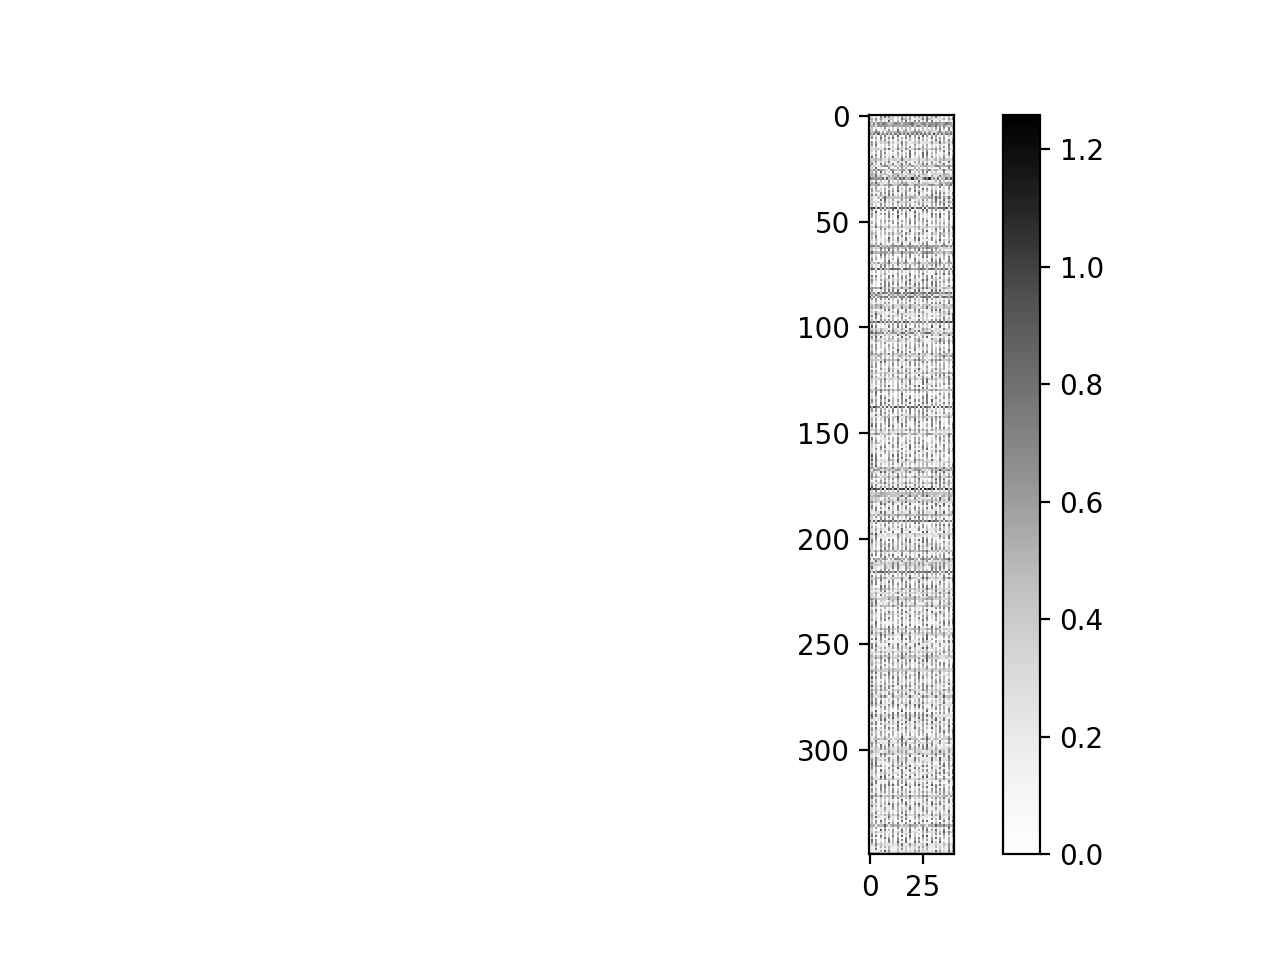

In [34]:
%matplotlib notebook 
plt.imshow(bit,cmap='Greys')
plt.colorbar()

<IPython.core.display.Javascript object>


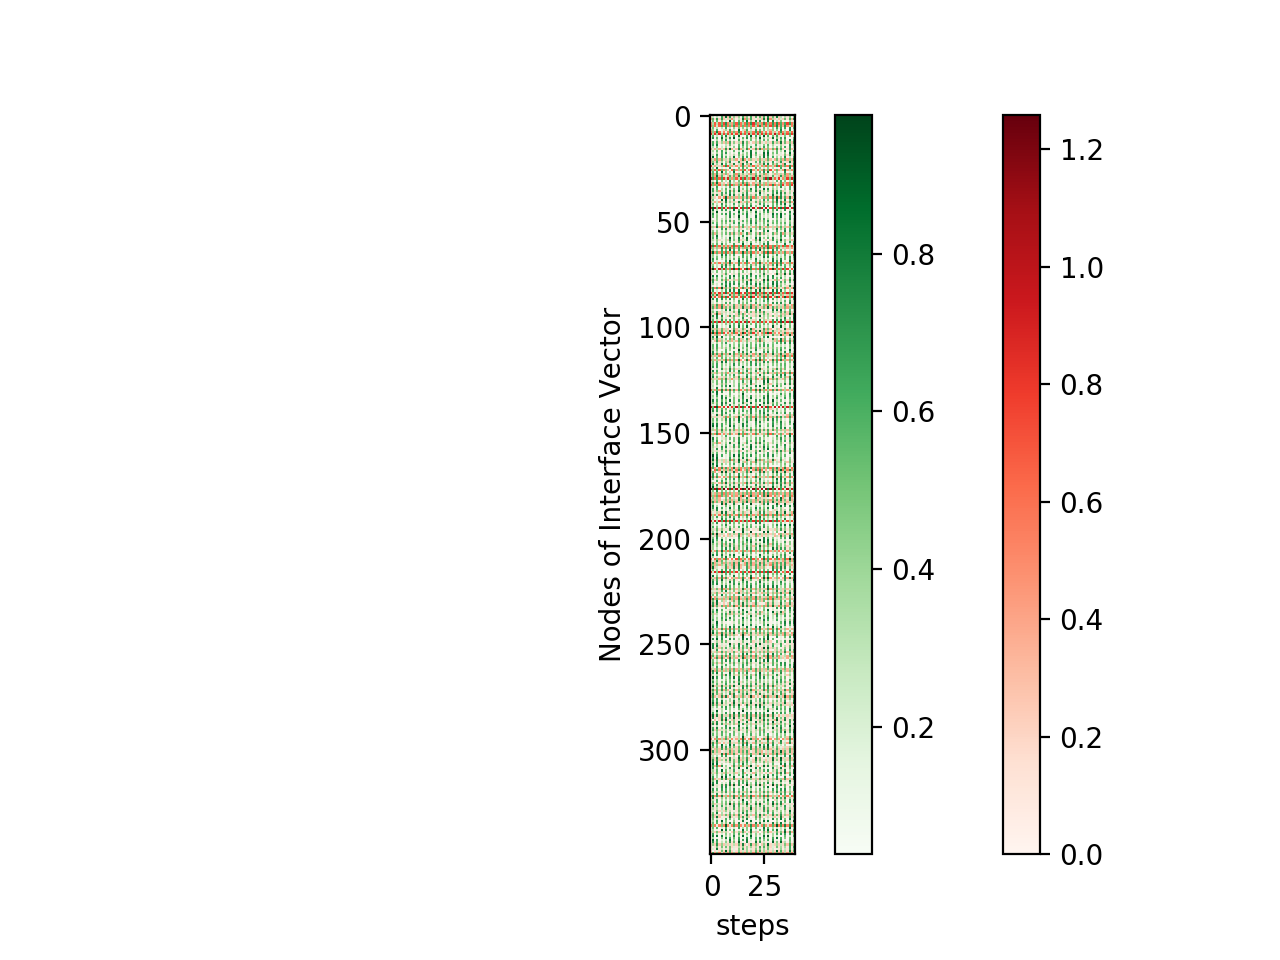

In [35]:
%matplotlib notebook
write = np.full(bit.shape, np.nan)
read = np.full(bit.shape, np.nan)
read[:,::2] = bit[:,::2]
write[:,1::2] = bit[:,1::2]
plt.imshow(read,cmap='Reds')
plt.colorbar()
plt.imshow(write,cmap='Greens')
plt.colorbar()
plt.xlabel("steps")
plt.ylabel("Nodes of Interface Vector")
plt.savefig('Read_write.png')

In [36]:
%matplotlib notebook
read_sep=np.zeros(shape=(interface_vactor_dim,test_num))
write_sep=np.zeros(shape=(interface_vactor_dim,test_num))
read_sep[:,::]=bit[:,::2]
write_sep[:,::]=bit[:,1::2]

### Read Vectro from  RN to Use in current step

<IPython.core.display.Javascript object>


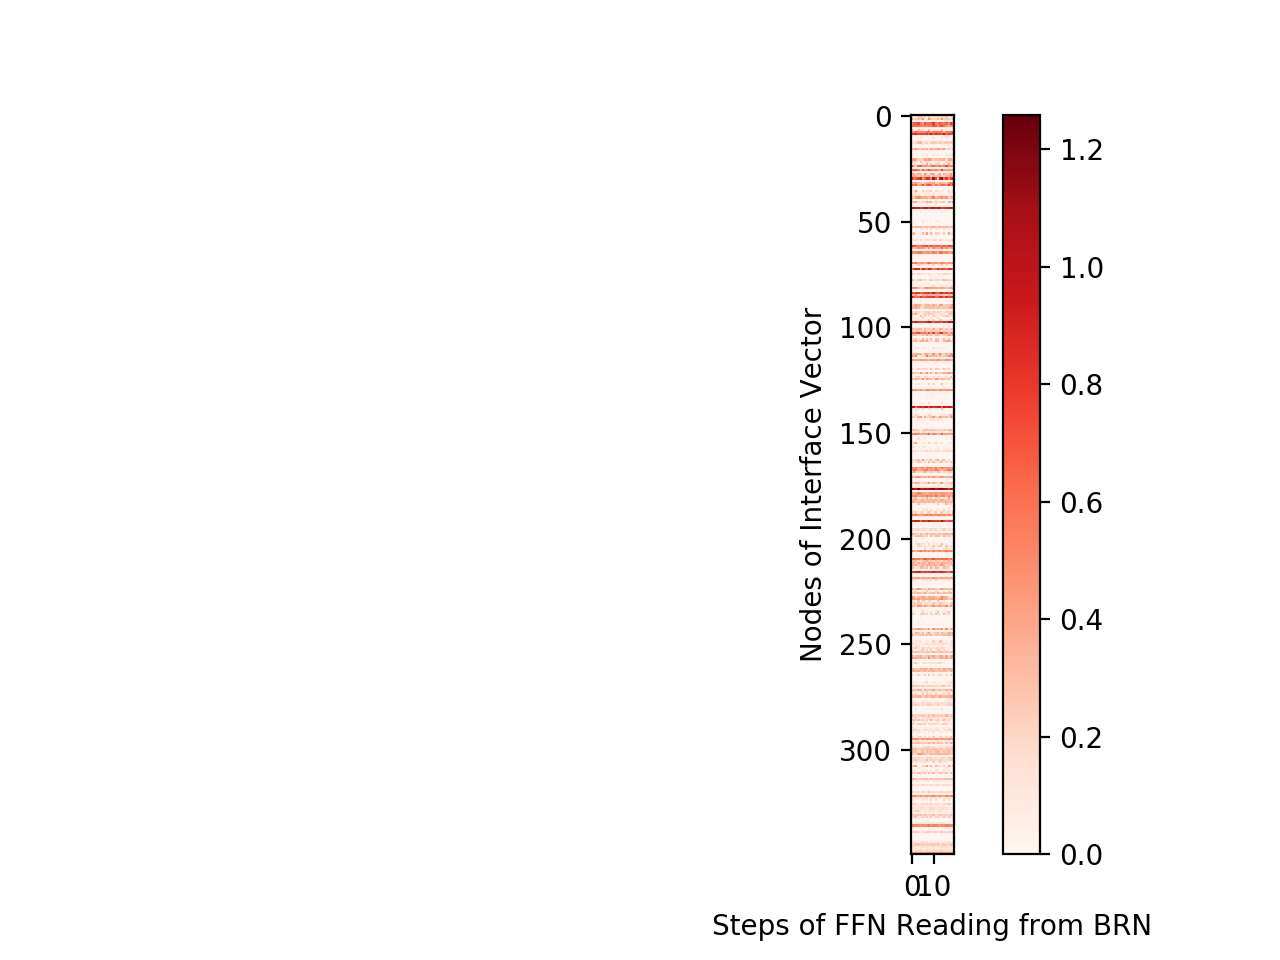

In [37]:
%matplotlib notebook
plt.imshow(read_sep,cmap='Reds')
plt.colorbar()
plt.xlabel("Steps of FFN Reading from BRN")
plt.ylabel("Nodes of Interface Vector")
plt.savefig('Read_from_BRN_vector.png')

### Write Vector to RN for Next step

<IPython.core.display.Javascript object>


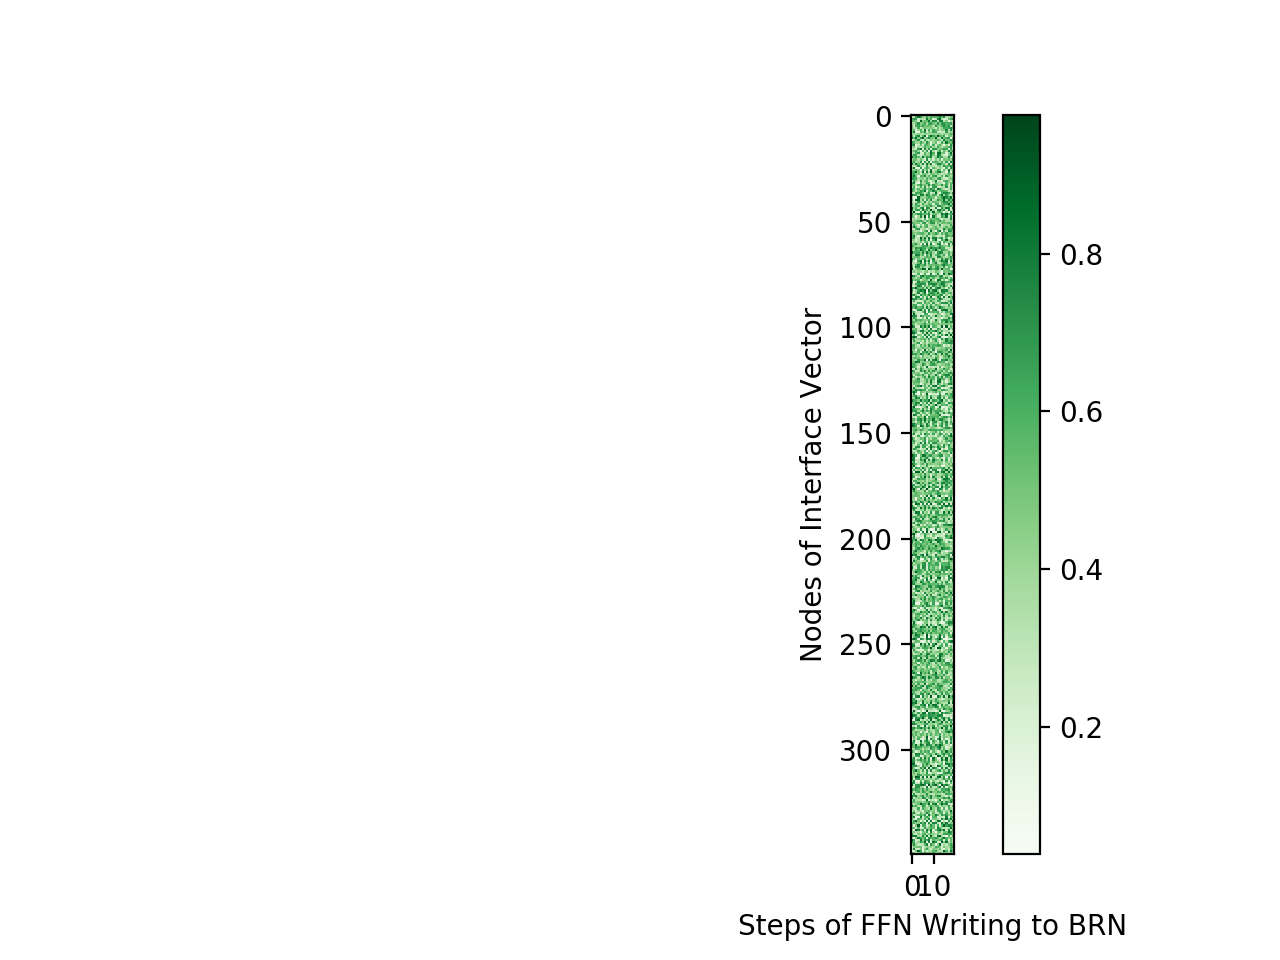

In [38]:
%matplotlib notebook
plt.imshow(write_sep,cmap='Greens')
plt.colorbar()
plt.xlabel("Steps of FFN Writing to BRN")
plt.ylabel("Nodes of Interface Vector")
plt.savefig('write_to_BRN_vector.png')

# Model Summery

In [39]:
dcwm.summary()

Model: "dcwm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dcwm_controller (Dense)      multiple                  182784    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  525312    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  524800    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  185706    
Total params: 1,549,646
Trainable params: 1,418,602
Non-trainable params: 131,044
_________________________________________________________________
